Nuevamente, basado en el gran trabajo de Manuel Ferreira de @Matewithcoffee 

https://twitter.com/Matewithcoffee

https://www.youtube.com/watch?v=lz-Csu3ce4s&feature=youtu.be

In [2]:
# Carga de librerías
import pandas as pd
from pandas.testing import assert_frame_equal
import numpy as np
import yfinance as yf

import matplotlib.dates as mpl_dates

# Librearías gráficas
import matplotlib.pyplot as plt
import mplfinance as mpf

MACD 192.36213911338473
MACD_signal 137.5781792482766
Strength 54.78395986510813


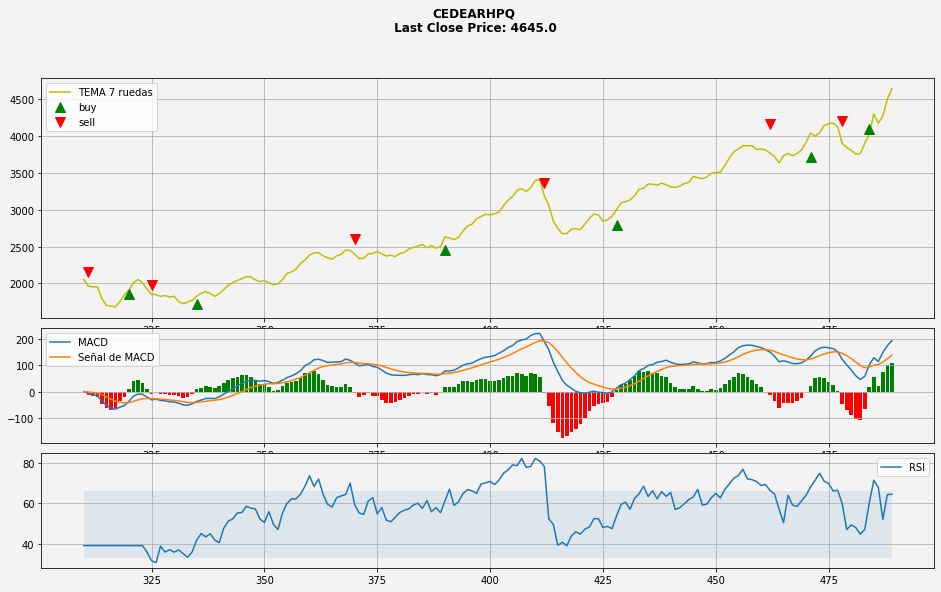

In [5]:
# Descarga de Cotización y limpieza
tick = 'CEDEARHPQ'


url = 'https://www.rava.com/empresas/precioshistoricos.php?e='+tick+'&csv=1'
df = pd.read_csv(url).tail(180)
df['fecha'] = pd.to_datetime(df['fecha'])
#df = df[df['volumen']>0]

# Hasta ahí no hay nada nuevo
# Manuel Ferreira: MEDIA MOVIL SIMPLE
df['SMA_7'] = df.iloc[:,3].rolling(window=7).mean()

# Media Móvil Exponencial
df['EMA_7'] = df.iloc[:,3].ewm(span=7, adjust=False).mean()

# Media Móvil Acumulada
df['CMA_7'] = df.iloc[:,3].expanding(min_periods=7).mean()

# Doble Media Móvil Exponencial
df['2_EMA_7'] = df.EMA_7.ewm(span=7, adjust=False).mean()
df['2_x_EMA_7'] = 2*(df['EMA_7'])
df['DEMA_7'] = df['2_x_EMA_7']-df['2_EMA_7']

# Triple Media Móvil Exponencial
df['3_EMA_7'] = df['2_EMA_7'].ewm(span=7, adjust=False).mean() # Media Movil Exponencial de la EMA de la EMA n=12
df['TEMA_7'] = (3*df['EMA_7'])-(3*df['2_EMA_7'])+df['3_EMA_7']

# TRIMA Media Móvil Triangular
df['TRIMA_7'] = df.SMA_7.rolling(window=7).mean()

# MACD
df['12d_EMA'] = df.loc[:,"cierre"].ewm(span=12, adjust=False).mean()
df['26d_EMA'] = df.loc[:,"cierre"].ewm(span=26, adjust=False).mean()
df['MACD'] = df['12d_EMA']- df['26d_EMA'] 

# Calcula MACD
df['MACD_signal'] = df.MACD.ewm(span=9, adjust=False).mean() 

# Calcula Fuerza de la Tendencia
df['Strength'] = (df['MACD']-df['MACD_signal'])

print('MACD',df['MACD'].iloc[-1])
print('MACD_signal',df['MACD_signal'].iloc[-1])
print('Strength',df['Strength'].iloc[-1])


# Calcular señales de Compra/Venta 
df['buy']=np.nan
df['sell']=np.nan
cruce = np.sign(df['Strength'].shift(1))!=np.sign(df['Strength'])
df.loc[cruce*np.sign(df['Strength'])==1.,'buy']=df['cierre']
df.loc[cruce*np.sign(df['Strength'])==-1.,'sell']=df['cierre']

# Cálculo de RSI

deltas = df.loc[:,"cierre"].diff()
seed = deltas[:14+1]
up = seed[seed >= 0].sum()/14
down = -seed[seed < 0].sum()/14

rs = up/down
rsi = np.zeros_like(df.iloc[:,3])
rsi[:14] = 100. - 100./(1.+rs)

for i in range(14, len(df.loc[:,'cierre'])):
    delta = deltas.iloc[i-1]  # cause the diff is 1 shorter

    if delta > 0:
        upval = delta
        downval = 0.
    else:
        upval = 0.
        downval = -delta

    up = (up*(14-1) + upval)/14
    down = (down*(14-1) + downval)/14

    rs = up/down
    rsi[i] = 100. - 100./(1.+rs)

    
df['RSI'] = rsi

df.set_index('fecha')

# Preparar grilla de charts
fig = plt.figure(facecolor='#f3f3f3',figsize=(16,10))
fig.suptitle(tick.upper()+'\n Last Close Price: '+str(df.iloc[-1].cierre),fontweight='bold')

fig.autofmt_xdate()
fig.set_label(tick)
fig.set_figsize=(20, 5)

ax0 = plt.subplot2grid((8,3), (0,0), rowspan=4, colspan=3, facecolor='#f3f3f3')

ax1 = plt.subplot2grid((8,3),(4,0), sharex=ax0, rowspan=2, colspan=3, facecolor='#f3f3f3')
ax2 = plt.subplot2grid((8,3),(6,0), sharex=ax0, rowspan=2, colspan=3, facecolor='#f3f3f3')


# Charts de valores
ax0.grid(True)
#ax0.plot(df.index,df['Close'],label='Cierre',linestyle='dashed')
ax0.plot(df.index,df['TEMA_7'],label='TEMA 7 ruedas',color='y')
ax0.plot(df.buy*.9, '^', c='g', markersize=10, label='buy')
ax0.plot(df.sell*1.1, 'v', c='r', markersize=10, label='sell')


#ohlc = df.reset_index().loc[:, ['fecha', 'apertura', 'maximo', 'minimo', 'cierre', 'volumen','openint']]

#ohlc['date'] = ohlc['fecha'].apply(mpl_dates.date2num)

#candlestick_ohlc(ax0, ohlc[['date','apertura','maximo','minimo','cierre']].values, width=0.6, colorup='green', colordown='red', alpha=0.8)

ax0.legend()

# Chart de MACD, MACD_signal, Fortaleza
ax1.grid(True)
ax1.plot(df['MACD'],label='MACD')
ax1.plot(df['MACD_signal'],label='Señal de MACD')
ax1.bar(df.index,df['Strength'].gt(0)*df['Strength']*2,color='g')
ax1.bar(df.index,df['Strength'].lt(0)*df['Strength']*2,color='r')
ax1.legend()

# Chart de RSI
ax2.grid(True)
ax2.plot(df['RSI'],label='RSI')
ax2.fill_between(df.index, 66, 33, alpha=0.1)
ax2.legend()

In [4]:
df


,fecha,apertura,maximo,minimo,cierre,volumen,openint,SMA_7,EMA_7,CMA_7,...,TEMA_7,TRIMA_7,12d_EMA,26d_EMA,MACD,MACD_signal,Strength,buy,sell,RSI
0,2020-09-07,6340.0,6493.0,6100.0,6270.0,3693179,0,NaN,6100.000000,NaN,...,6100.000000,NaN,6270.000000,6270.000000,0.000000,0.000000,0.000000,NaN,NaN,44.702666
1,2020-09-08,6270.0,6350.0,6200.0,6320.0,13314126,0,NaN,6125.000000,NaN,...,6157.812500,NaN,6277.692308,6273.703704,3.988604,0.797721,3.190883,6320.0,NaN,44.702666
2,2020-09-09,6350.0,6440.0,6348.0,6377.0,29660802,0,NaN,6180.750000,NaN,...,6275.015625,NaN,6292.970414,6281.355281,11.615133,2.961203,8.653930,NaN,NaN,44.702666
3,2020-09-10,6375.0,6428.5,6370.0,6415.0,31655656,0,NaN,6228.062500,NaN,...,6350.382812,NaN,6311.744197,6291.254890,20.489307,6.466824,14.022483,NaN,NaN,44.702666
4,2020-09-11,6410.0,6505.0,6395.0,6401.0,36047588,0,NaN,6269.796875,NaN,...,6401.802734,NaN,6325.475859,6299.384157,26.091701,10.391799,15.699902,NaN,NaN,44.702666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2021-03-04,5319.0,5340.5,5275.5,5279.0,599825,0,5175.000000,5208.136902,5742.424370,...,5292.360784,5077.010204,5268.589195,5366.285713,-97.696518,-113.790900,16.094382,NaN,NaN,42.628978
119,2021-03-05,5303.0,5303.0,5200.5,5215.0,162290,0,5209.357143,5206.227677,5737.908333,...,5262.495464,5097.673469,5260.344703,5355.079364,-94.734660,-109.979652,15.244991,NaN,NaN,41.718240
120,2021-03-08,5238.0,5238.0,5131.0,5215.0,381367,0,5222.428571,5187.420757,5732.892562,...,5201.910303,5126.704082,5253.368595,5344.703115,-91.334519,-106.250625,14.916106,NaN,NaN,37.473652
121,2021-03-09,5198.0,5199.5,5085.0,5109.0,29040,0,5208.142857,5161.815568,5727.581967,...,5139.450228,5153.591837,5231.158042,5327.243625,-96.085583,-104.217617,8.132034,NaN,NaN,37.473652
